# Information Retrieval - Quora Question Pairs challenge
by Kevin Nanhekhan (student-no. 4959094)

In [1]:
import json
from flaml import AutoML
from rapidfuzz import fuzz
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, HalvingGridSearchCV
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import skew, kurtosis
from scipy.sparse import hstack
from scipy.spatial.distance import cosine, cityblock, canberra, euclidean, minkowski, braycurtis
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
tqdm.pandas()
from xgboost import XGBClassifier
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')

STOPWORDS = stopwords.words('english')
RANDOM_STATE = 42
model = SentenceTransformer('distilbert-multilingual-nli-stsb-quora-ranking') #SentenceBert
# model = SentenceTransformer('all-MiniLM-L6-v2') # alternative model
shuffle = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('data/Development set.csv', index_col='id')
data.head()

qid1  qid2                                          question1  \
id                                                                  
0      1     2  What is the step by step guide to invest in sh...   
1      3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2      5     6  How can I increase the speed of my internet co...   
3      7     8  Why am I mentally very lonely? How can I solve...   
4      9    10  Which one dissolve in water quikly sugar, salt...   

                                            question2  is_duplicate  
id                                                                   
0   What is the step by step guide to invest in sh...             0  
1   What would happen if the Indian government sto...             0  
2   How can Internet speed be increased by hacking...             0  
3   Find the remainder when [math]23^{24}[/math] i...             0  
4             Which fish would survive in salt water?             0

Percentage non-duplicates: 63.1% and duplicates: 36.9% shows the dataset is imbalanced.


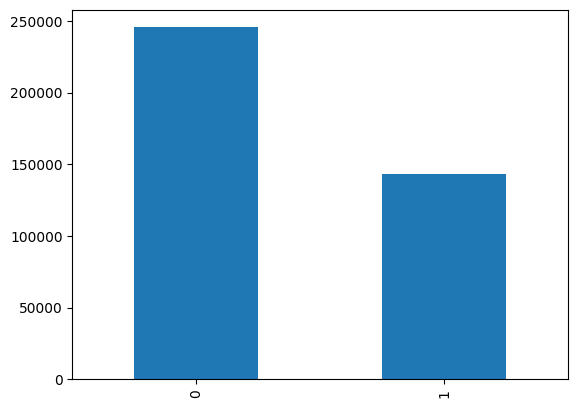

In [3]:
# Dataset has an imbalance when looking at the amount of non-duplicated vs duplicated questions
data['is_duplicate'].value_counts().plot.bar()
num_no_duplicate, num_duplicate = (data['is_duplicate'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
print(f'Percentage non-duplicates: {num_no_duplicate} and duplicates: {num_duplicate} shows the dataset is imbalanced.')

# Initial Solution
Perform string matching and basic preprocessing on the question text (e.g. lower case, replace characters, lematization, stopword removal)

In [2]:
def load_json(file_path):
    with open(file_path, 'r') as f:
        jdict = json.load(f)
        return dict((re.escape(key), value) for key, value in jdict.items())

# Compiled regular expressions for reuse
jsondict = load_json('data/replacechars.json')
dict_pattern = re.compile("|".join(jsondict.keys()))
billion = re.compile(r'([0-9]+)000000000')
million = re.compile(r'([0-9]+)000000')
thousand = re.compile(r'([0-9]+)000')
non_word = re.compile('\W')
hyperlink = re.compile(r"http\S+")

def text_preprocess(txt):
    # Change text to be lowercase.
    txt = str(txt).lower()

    # Replace contractions, currencies, magnitude of order and remove non-word characters and hyperlinks
    txt = dict_pattern.sub(lambda match: jsondict[re.escape(match.group())], txt)
    txt = billion.sub(r'\1b', txt)
    txt = million.sub(r'\1m', txt)
    txt = thousand.sub(r'\1k', txt)
    txt = non_word.sub(' ', txt)
    txt = hyperlink.sub('', txt)

    # Lemmatize text (e.g. corpora -> corpus)
    txt =  WordNetLemmatizer().lemmatize(txt)

    return txt.strip()

In [3]:
def string_matching(df_name):
    df_str = pd.read_csv(df_name, index_col='id')
    print('Question 1 text preprocessing:')
    df_str['question1'] = df_str['question1'].fillna("").progress_apply(text_preprocess)
    print('Question 2 text preprocessing:')
    df_str['question2'] = df_str['question2'].fillna("").progress_apply(text_preprocess)
    df_str['is_duplicate'] = (df_str['question1'] == df_str['question2']).astype(int)
    return df_str

# Creating prediction results csv for Kaggle
# df_string_match = string_matching('data/Test set.csv')
# df_string_match['is_duplicate'].to_csv('results/string_match.csv')

Question 1 text preprocessing:


  0%|          | 0/388800 [00:00<?, ?it/s]

Question 2 text preprocessing:


  0%|          | 0/388800 [00:00<?, ?it/s]

Accuracy score: 0.63290
F1 score: 0.00993


[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

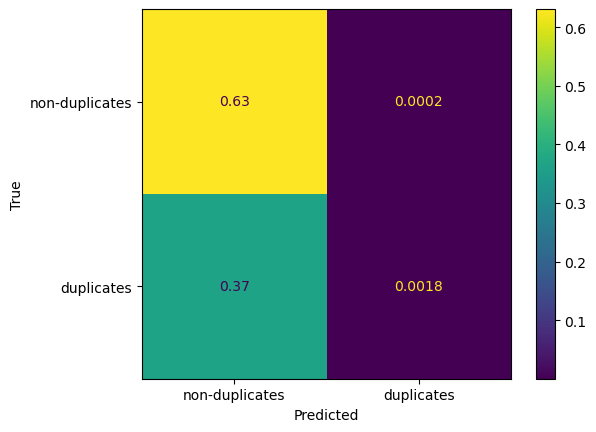

In [4]:
df_string_match = pd.read_csv('data/Development set.csv', index_col='id')
y_true = df_string_match['is_duplicate'].values
y_pred = string_matching('data/Development set.csv')['is_duplicate'].values
print(f'Accuracy score: {accuracy_score(y_true, y_pred):.5f}')
print(f'F1 score: {f1_score(y_true, y_pred):.5f}')

cmd = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred, normalize="all"), display_labels=['non-duplicates', 'duplicates'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

# Improvement towards advanced solution
### Feature extraction
Features extracted following the paper: Identifying Semantically Duplicate Questions Using Data Science Approach: A Quora Case Study by Navedanjum Ansari, Rajesh Sharma.

In [2]:
def matchWord(row, idx):
    """"
    Helper method for matching words
    """
    q1 = row['question1'].split()
    q2 = row['question2'].split()
    if len(q1)>0 and len(q2)>0 and q1[idx]==q2[idx]:
        return 1
    else:
        return 0

def basic_features(df_basic):
    """"
    Helper function for extracting basic features (e.g. calculations based on the length and number of occurrences of words and characters)
    """
    stop_words = set(STOPWORDS)

    df_basic['q1_char'] = df_basic['question1'].apply(len)
    df_basic['q2_char'] = df_basic['question2'].apply(len)
    df_basic['q1_word'] = df_basic['question1'].apply(lambda x: len(x.split()))
    df_basic['q2_word'] = df_basic['question2'].apply(lambda x: len(x.split()))
    df_basic['total_words'] = df_basic['q1_word'] + df_basic['q2_word']
    df_basic['differ_words'] = abs(df_basic['q1_word'] - df_basic['q2_word'])
    df_basic['first_word'] = df_basic.apply(lambda x: matchWord(x, 0) ,axis=1)
    df_basic['last_word'] = df_basic.apply(lambda x: matchWord(x, -1) ,axis=1)

    df_basic['unique_words'] = df_basic.apply(lambda x: len(set(x['question1'].split()) | (set(x['question2'].split()))) ,axis=1)
    df_basic['unique_words_nostopword'] = df_basic.apply(lambda x: len((set(x['question1'].split()) | set(x['question2'].split())) - stop_words) ,axis=1)
    df_basic['unique_ratio'] = df_basic['unique_words'] / df_basic['total_words']

    df_basic['common_words'] = df_basic.apply(lambda x: len(set(x['question1'].split()) & set(x['question2'].split())) ,axis=1)
    df_basic['common_ratio'] = df_basic['common_words'] / df_basic['unique_ratio']
    df_basic['common_ratio_min'] = df_basic['common_words'] / df_basic.apply(lambda x: min(len(set(x['question1'].split())), len(set(x['question2'].split()))) ,axis=1)
    df_basic['common_ratio_max'] = df_basic['common_words'] / df_basic.apply(lambda x: max(len(set(x['question1'].split())), len(set(x['question2'].split()))) ,axis=1)

    df_basic['common_nostopwords'] = df_basic.apply(lambda x: len(set(x['question1'].split()) & set(x['question2'].split()) - stop_words) ,axis=1)
    df_basic['common_nostopword_ratio'] = df_basic['common_nostopwords'] / df_basic['unique_words_nostopword']
    df_basic['common_nostopwords_ratio_min'] = df_basic['common_nostopwords'] / df_basic.apply(lambda x: min(len(set(x['question1'].split()) - stop_words), len(set(x['question2'].split()) - stop_words)) ,axis=1)
    df_basic['common_nostopwords_ratio_max'] = df_basic['common_nostopwords'] / df_basic.apply(lambda x: max(len(set(x['question1'].split()) - stop_words), len(set(x['question2'].split()) - stop_words)) ,axis=1)

    return df_basic

def fuzzy_features(q1, q2):
    """"
    Helper function for extracting similarity scores between 0-100 by using RapidFuzz (cython alternative to FuzzyWuzzy)
    """
    features = np.zeros(7)

    features[0] = fuzz.QRatio(q1, q2)                     # quick ratio comparison
    features[1] = fuzz.WRatio(q1, q2)                     # weighted ratio comparison
    features[2] = fuzz.partial_ratio(q1, q2)              # partial ratio
    features[3] = fuzz.token_set_ratio(q1, q2)            # Token set ratio
    features[4] = fuzz.token_sort_ratio(q1, q2)           # Token sort ratio
    features[5] = fuzz.partial_token_set_ratio(q1, q2)    # Partial token set ratio
    features[6] = fuzz.partial_token_sort_ratio(q1, q2)   # Partial token sort ratio

    return features

def jaccard_distance(str1, str2):
    """"
    Calculates jaccard distance between strings
    Note: Used as alternative to scipy jaccard function as I got 100 for all text embeddings.
    """
    set1 = set(str1.split())
    set2 = set(str2.split())
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    if union == 0:
        return 0.0
    return 1 - len(intersection) / len(union)

def distance_features(q1, q2):
    """"
    Helper function for extracting distance features by using distance metrics on text embeddings (SentenceBert/SentenceTransformer).
    """
    features = np.zeros(11)
    # Text embedding of the provided questions using SentenceTransformer (SentenceBERT)
    q1_vec = model.encode(q1)
    q2_vec = model.encode(q2)

    features[0] = cosine(q1_vec, q2_vec)          # cosine distance - angle between the word vectors of two question sentences
    features[1] = minkowski(q1_vec, q2_vec, 3)    # minkowski - sum of differences of vector dimes to the power p and whole raise to the inverse of power p
    features[2] = cityblock(q1_vec, q2_vec)       # cityblock - special case of Minkowski distance metric when we use the value of p=1
    features[3] = euclidean(q1_vec, q2_vec)       # euclidean on embedding - special case of Minkowski distance metric when we use the value of p=2
    features[4] = jaccard_distance(q1, q2)        # jaccard - ratio of intersection between two vectors sets to the union of two vector sets
    features[5] = canberra(q1_vec, q2_vec)        # canberra -sum of the absolute difference of two vector points divided by the absolute sum of individual vector points
    features[6] = braycurtis(q1_vec, q2_vec)      # braycurtis - Sorenson distance and alternative to Manhattan distance
    features[7] = skew(q1_vec)                    # q1 skewness - deviation tendency from the mean in one of the direction
    features[8] = skew(q2_vec)                    # q2 skewness
    features[9] = kurtosis(q1_vec)                # q1 kurtosis - measure of dense distribution towards the tails of the distribution
    features[10] = kurtosis(q2_vec)               # q2 kurtosis

    return features


def dataframe_features(df_name, readfile=True):
    """
    Create features from dataframe. Has optional readfile parameter as running the function can take some hours due to the distance feature extraction.
    """
    if readfile:
        return pd.read_csv(f'data/{df_name} features.csv', index_col='id')
    else:
        # training set
        df_features = pd.read_csv(f"data/{df_name} set.csv", index_col='id')

        # Remove redundant question id's and replace NaN questions with empty strings
        df_features.drop(columns=['qid1', 'qid2', '?'], inplace=True, errors='ignore')
        df_features[['question1', 'question2']] = df_features[['question1', 'question2']].fillna('')

        print('Text preprocessing:')
        df_features['question1'] = df_features['question1'].progress_apply(text_preprocess)
        df_features['question2'] = df_features['question2'].progress_apply(text_preprocess)

        print('Perform Basic feature extraction:')
        df_features = basic_features(df_features)

        print('complete\n RapidFuzz feature extraction:')
        feature_cols = ['fz_qratio', 'fz_wratio', 'fz_partial', 'fz_token_set', 'fz_token_sort', 'fz_partial_set', 'fz_partial_sort']
        df_features[feature_cols] = df_features.progress_apply(lambda q: fuzzy_features(q['question1'], q['question2']), axis=1, result_type='expand')

        df_features.to_csv(f'intermediate {df_name}.csv')

        print('Distance measure feature extraction:')
        df_features[['question1', 'question2']] = df_features[['question1', 'question2']].fillna('')
        feature_cols = ['cosine', 'minkowski', 'cityblock', 'euclidean', 'jaccard', 'canberra', 'braycurtis', 'q1_skew', 'q2_skew', 'q1_kurtosis', 'q2_kurtosis']
        df_features[feature_cols] = df_features.progress_apply(lambda q: distance_features(q['question1'], q['question2']), axis=1, result_type='expand')

        # Ensure no NaN values are in the features
        df_features.fillna(0, inplace=True)

        # Write to csv for future use
        df_features.to_csv(f'data/{df_name} features.csv')

        return df_features

# Comparison Tree-based models:
## Random Forest Classifier and XGBoost Classifier (Gradient Boosted Trees Classifier)
Note: Parameters were chosen following the research paper: Natural Language Understanding with the Quora Question Pairs Datase by Sharma et al.

In [3]:
def predict_classifier(classifier, cl_train, cl_labels):
    x1, x2, y1, y2 = train_test_split(cl_train, cl_labels, test_size=0.2, random_state=RANDOM_STATE)
    classifier.fit(x1, y1)
    y2_pred = classifier.predict(x2)
    return y2, y2_pred

# Plots Confusion matrix
def plot_confusionmatrix(true_labels, pred_labels, title, num_plots, classifier_name):
    if num_plots > 1:
        fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(16,4))
        fig.suptitle(classifier_name, fontsize=12)
        for idx, ax in enumerate(axes.flatten()):
            true_values = true_labels[idx]
            pred_values = pred_labels[idx]
            print(f'{title[idx]} - Accuracy score: {accuracy_score(true_values, pred_values):.5f} and F1 score: {f1_score(true_values, pred_values):.5f}')
            display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(true_values, pred_values, normalize="all"), display_labels=['False', 'True'])
            display.plot(ax=ax)
            display.im_.colorbar.remove()
            display.ax_.set_title(title[idx])
            if idx != 0:
                display.ax_.set_ylabel('')
        plt.subplots_adjust(wspace=0.40, hspace=0.1)
        fig.colorbar(display.im_, ax=axes, fraction=0.046)
        plt.show()

    else:
        display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(true_labels, pred_labels , normalize="all"), display_labels=['False', 'True'])
        display.plot()
        display.ax_.set(xlabel='Predicted', ylabel='True')
        display.ax_.set_title(title)
        print(f'Accuracy score: {accuracy_score(true_labels, pred_labels):.5f} and F1 score: {f1_score(true_labels, pred_labels):.5f}')

In [18]:
df_dev = dataframe_features('Development')

# Stand alone features
basic_feats = df_dev.iloc[:, 3:12].values
fuzz_feats = df_dev.iloc[:, 12:19].values
distance_feats = df_dev.iloc[:, 19:].values

# Combination of features
basic_fuzz_feats = df_dev.iloc[:, 3:19].values
basic_distance_feats = np.concatenate([basic_feats, distance_feats], axis=1)
fuzz_distance_feats = df_dev.iloc[:, 12:].values
all_feats = df_dev.iloc[:, 3:].values

# Labels indicating whether the questions are duplicate or not
labels = df_dev['is_duplicate'].values

Basic Features - Accuracy score: 0.71876 and F1 score: 0.60862
Fuzzy Features - Accuracy score: 0.72191 and F1 score: 0.62927
Distance Features - Accuracy score: 0.82141 and F1 score: 0.76681


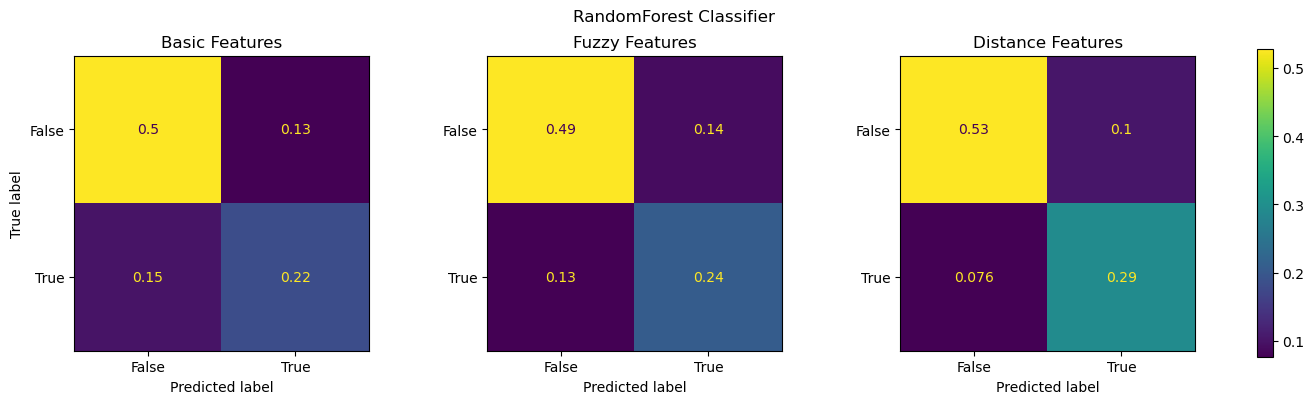

In [19]:
rf_true_labels =[]
rf_pred_labels = []
titles = ['Basic Features', 'Fuzzy Features', 'Distance Features']

for feature in [basic_feats, fuzz_feats, distance_feats]:
    rf = RandomForestClassifier(max_depth=None, min_samples_leaf=5, n_estimators=50)
    rf_true, rf_pred = predict_classifier(rf, feature, labels)
    rf_true_labels.append(rf_true)
    rf_pred_labels.append(rf_pred)

plot_confusionmatrix(rf_true_labels, rf_pred_labels, titles, 3, 'RandomForest Classifier')

Basic + Fuzzy Features - Accuracy score: 0.74997 and F1 score: 0.66338
Basic + Distance Features - Accuracy score: 0.82964 and F1 score: 0.77760
Fuzzy + Distance Features - Accuracy score: 0.82566 and F1 score: 0.77216
All features - Accuracy score: 0.83054 and F1 score: 0.77858


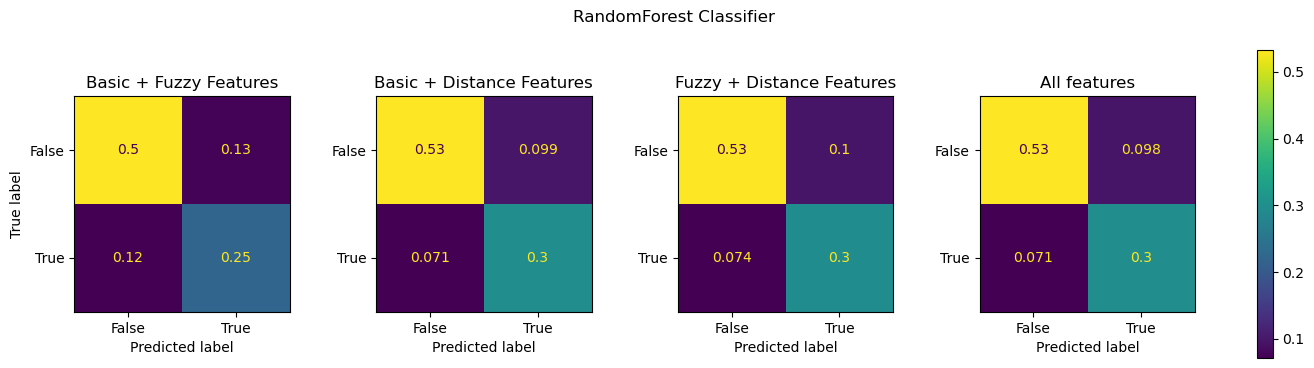

In [20]:
rf_true_labels =[]
rf_pred_labels = []
titles = ['Basic + Fuzzy Features', 'Basic + Distance Features', 'Fuzzy + Distance Features', 'All features']

for feature in [basic_fuzz_feats, basic_distance_feats, fuzz_distance_feats, all_feats]:
    rf = RandomForestClassifier(max_depth=None, min_samples_leaf=5, n_estimators=50)
    rf_true, rf_pred = predict_classifier(rf, feature, labels)
    rf_true_labels.append(rf_true)
    rf_pred_labels.append(rf_pred)

plot_confusionmatrix(rf_true_labels, rf_pred_labels, titles, 4, 'RandomForest Classifier')

Basic Features - Accuracy score: 0.72151 and F1 score: 0.60255
Fuzzy Features - Accuracy score: 0.72612 and F1 score: 0.64087
Distance Features - Accuracy score: 0.82614 and F1 score: 0.77316


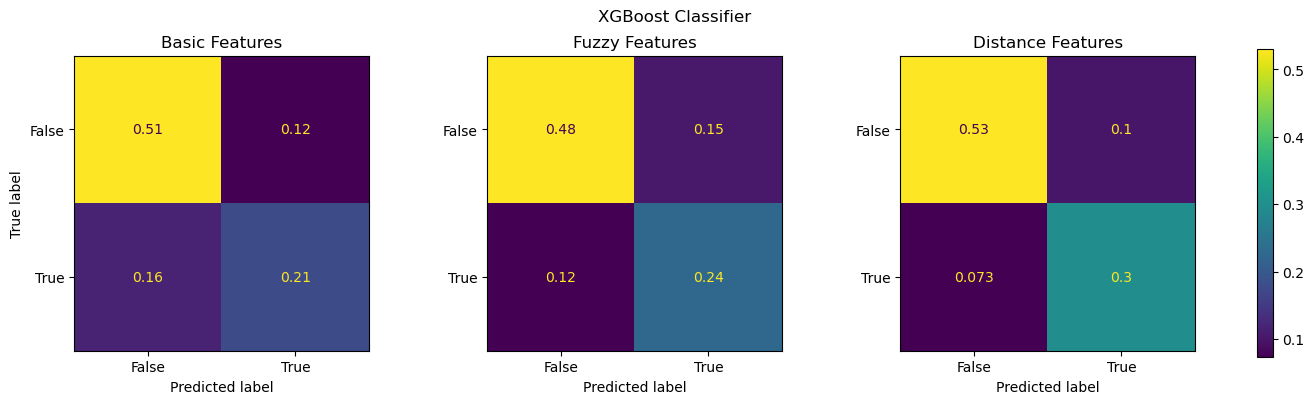

In [21]:
xgb_true_labels = []
xgb_pred_labels = []
titles = ['Basic Features', 'Fuzzy Features', 'Distance Features']

for feature in [basic_feats, fuzz_feats, distance_feats]:
    xgb = XGBClassifier(max_depth=4, n_estimators=500)
    xgb_true, xgb_pred = predict_classifier(xgb, feature, labels)
    xgb_true_labels.append(xgb_true)
    xgb_pred_labels.append(xgb_pred)

plot_confusionmatrix(xgb_true_labels, xgb_pred_labels, titles, 3, 'XGBoost Classifier')

Basic + Fuzzy Features - Accuracy score: 0.75226 and F1 score: 0.66699
Basic + Distance Features - Accuracy score: 0.83479 and F1 score: 0.78430
Fuzzy + Distance Features - Accuracy score: 0.83031 and F1 score: 0.77904
All features - Accuracy score: 0.83557 and F1 score: 0.78535


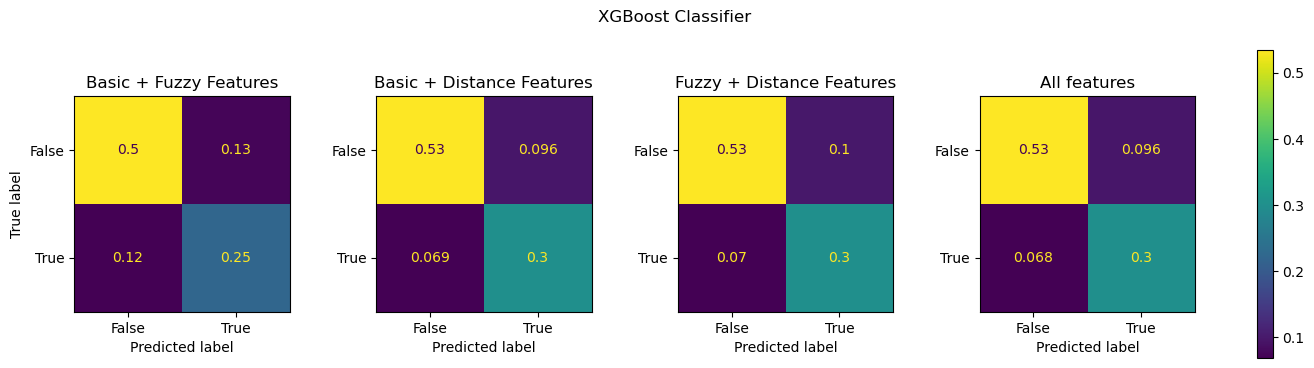

In [22]:
xgb_true_labels = []
xgb_pred_labels = []
titles = ['Basic + Fuzzy Features', 'Basic + Distance Features', 'Fuzzy + Distance Features', 'All features']

for feature in [basic_fuzz_feats, basic_distance_feats, fuzz_distance_feats, all_feats]:
    xgb = XGBClassifier(max_depth=4, n_estimators=500)
    xgb_true, xgb_pred = predict_classifier(xgb, feature, labels)
    xgb_true_labels.append(xgb_true)
    xgb_pred_labels.append(xgb_pred)

plot_confusionmatrix(xgb_true_labels, xgb_pred_labels, titles, 4, 'XGBoost Classifier')

### Sparse Features: Unigram and TF-IDF (character level)

In [5]:
def unigram_featurize(num_feats):
    """
    Create sparse features using Bag-of-Words vectorizer
    """
    df_unigram = pd.read_csv('data/Development set.csv', index_col='id')
    df_unigram.fillna('', inplace=True)
    c_vect = CountVectorizer(max_features=num_feats)
    c_vect.fit(pd.concat((df_unigram['question1'],df_unigram['question2'])).unique())
    q1_vect = c_vect.transform(df_unigram['question1'].values)
    q2_vect = c_vect.transform(df_unigram['question2'].values)
    train_data = hstack((q1_vect,q2_vect))
    train_labels = df_unigram['is_duplicate'].values
    return train_data, train_labels

def tfidf_featurize(num_feats):
    """"
    Create sparse features using TF-IDF vectorizer
    """
    df_tfidf = pd.read_csv('data/Development set.csv', index_col='id')
    df_tfidf.fillna('', inplace=True)
    tfidf_vect = TfidfVectorizer(analyzer='char', max_features=num_feats)
    tfidf_vect.fit(pd.concat((df_tfidf['question1'],df_tfidf['question2'])).unique())
    q1_vect = tfidf_vect.transform(df_tfidf['question1'].values)
    q2_vect = tfidf_vect.transform(df_tfidf['question2'].values)
    train_data = hstack((q1_vect,q2_vect))
    train_labels = df_tfidf['is_duplicate'].values
    return train_data, train_labels

RandomForest - BOW - Accuracy score: 0.75267 and F1 score: 0.56235
XGBoost - BOW - Accuracy score: 0.76930 and F1 score: 0.63737
RandomForest - TF-IDF - Accuracy score: 0.65918 and F1 score: 0.15139
XGBoost - TF-IDF - Accuracy score: 0.75336 and F1 score: 0.64256


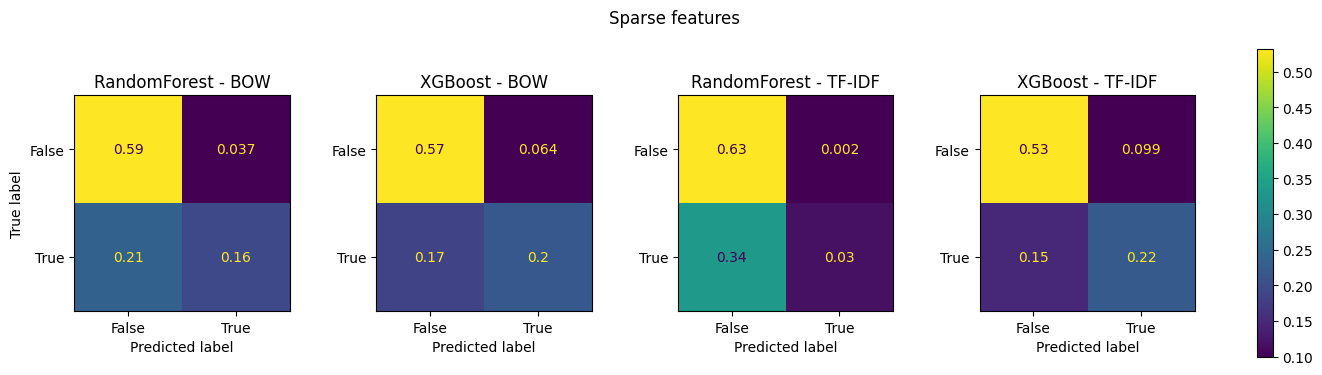

In [22]:
unigram_train, unigram_labels = unigram_featurize(5000)
tfidf_train, tfidf_labels = tfidf_featurize(5000)

sparse_true_labels = []
sparse_pred_labels = []
titles = ['RandomForest - Unigram', 'XGBoost - Unigram', 'RandomForest - TF-IDF', 'XGBoost - TF-IDF']

for train, label in zip([unigram_train, tfidf_train], [unigram_labels, tfidf_labels]):
    rf = RandomForestClassifier(max_depth=None, min_samples_leaf=5, n_estimators=50)
    rf_true, rf_pred = predict_classifier(rf, train, label)
    sparse_true_labels.append(rf_true)
    sparse_pred_labels.append(rf_pred)

    xgb = XGBClassifier(max_depth=4, n_estimators=500)
    xgb_true, xgb_pred = predict_classifier(xgb, train, label)
    sparse_true_labels.append(xgb_true)
    sparse_pred_labels.append(xgb_pred)

plot_confusionmatrix(sparse_true_labels, sparse_pred_labels, titles, 4, 'Sparse features')

#### Attempt at combining the Custom (Basic + Fuzzy + Distance) features with the Sparse features but crashes due to memory errors

In [6]:
# unigram_train, unigram_labels = unigram_featurize(5000)
# df_unigram = pd.DataFrame.sparse.from_spmatrix(unigram_train)
# df_combined_unigram = pd.concat([df_feats, df_unigram])

# tfidf_train, tfidf_labels = tfidf_featurize(5000)
# df_tfidf = pd.DataFrame.sparse.from_spmatrix(tfidf_train)
# df_combined_tfidf = pd.concat([df, df_tfidf])

MemoryError: Unable to allocate 2.97 MiB for an array with shape (388800, 1) and data type int64

In [ ]:
# sparse_true_labels = []
# sparse_pred_labels = []
# titles = ['RF - Custom + Unigram', 'XGB - Custom + Unigram', 'RF - Custom + TF-IDF', 'XGB - Custom + TF-IDF']
#
# for train, label in zip([df_combined_bow, df_combined_tfidf], [bow_labels, tfidf_labels]):
#     rf = RandomForestClassifier(max_depth=None, min_samples_leaf=5, n_estimators=50)
#     rf_true, rf_pred = predict_classifier(rf, train, label)
#     sparse_true_labels.append(rf_true)
#     sparse_pred_labels.append(rf_pred)
#
#     xgb = XGBClassifier(max_depth=4, n_estimators=500)
#     xgb_true, xgb_pred = predict_classifier(xgb, train, label)
#     sparse_true_labels.append(xgb_true)
#     sparse_pred_labels.append(xgb_pred)
#
# plot_confusionmatrix(sparse_true_labels, sparse_pred_labels, titles, 4, 'Custom + Sparse features')

# Hyperparameter Tuning the models

In [28]:
def hyperparameter_tuning(classifier, param_grid, name):
    df_param = dataframe_features('Development')
    df_param.drop(columns=['question1', 'question2'], inplace=True)
    df_param_x = df_param.loc[:, df_param.columns!='is_duplicate'].values
    df_param_y = df_param['is_duplicate'].values

    scaler = MinMaxScaler()
    df_param_x = scaler.fit_transform(df_param_x)

    #Faster alternative to GridSearchCV
    clf_search = HalvingGridSearchCV(estimator=classifier, param_grid=param_grid, scoring="accuracy", cv=shuffle, verbose=3, random_state=RANDOM_STATE)
    clf_search.fit(df_param_x, df_param_y)
    print(f"Best parameters found for {name}: {clf_search.best_params_}, best accuracy score: {clf_search.best_score_:.5f}")

In [30]:
rf_param_grid = {
    'n_estimators':[50, 75, 100, 150, 200, 300, 400],
    'min_samples_split':[7, 10, 12, 15],
    'min_samples_leaf': [1, 2, 4, 5],
    'max_depth': [50, 75, 100, 150, 175, 200, None]
}
# hyperparameter_tuning(RandomForestClassifier(), rf_param_grid, 'RandomForest Classifier')

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 533
max_resources_: 388800
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1680
n_resources: 533
Fitting 1 folds for each of 1680 candidates, totalling 1680 fits
[CV 1/1] END max_depth=50, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=(train=0.995, test=0.821) total time=   0.0s
[CV 1/1] END max_depth=50, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=(train=0.988, test=0.821) total time=   0.0s
[CV 1/1] END max_depth=50, min_samples_leaf=1, min_samples_split=5, n_estimators=75;, score=(train=0.995, test=0.792) total time=   0.1s
[CV 1/1] END max_depth=50, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=(train=0.991, test=0.821) total time=   0.1s
[CV 1/1] END max_depth=50, min_samples_leaf=1, min_samples_split=5, n_estimators=150;, score=(train=0.998, test=0.821) total time=   0.2s
[CV 1/1] END max_depth=50, min_samples_leaf=

In [31]:
xgb_param_grid = {
    'n_estimators':[500, 600, 700, 800],
    'learning_rate': [0.001, 0.002, 0.005, 0.01],
    'max_depth': [4, 8, 12, 16, 20, None],
    'subsample': [0.7, 0.75, 0.8, 0.85],
    'reg_alpha': [0, 1, 2],
    'reg_lambda': [0, 1, 2, 4]
}
# hyperparameter_tuning(XGBClassifier(), xgb_param_grid, 'XGBoost Classifier')

n_iterations: 10
n_required_iterations: 10
n_possible_iterations: 10
min_resources_: 19
max_resources_: 388800
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 33600
n_resources: 19
Fitting 1 folds for each of 33600 candidates, totalling 33600 fits
[CV 1/1] END learning_rate=0.001, max_depth=10, n_estimators=25, reg_alpha=0, reg_lambda=0, subsample=0.7;, score=(train=0.933, test=1.000) total time=   0.0s
[CV 1/1] END learning_rate=0.001, max_depth=10, n_estimators=25, reg_alpha=0, reg_lambda=0, subsample=0.75;, score=(train=0.933, test=1.000) total time=   0.0s
[CV 1/1] END learning_rate=0.001, max_depth=10, n_estimators=25, reg_alpha=0, reg_lambda=0, subsample=0.8;, score=(train=0.933, test=1.000) total time=   0.0s
[CV 1/1] END learning_rate=0.001, max_depth=10, n_estimators=25, reg_alpha=0, reg_lambda=0, subsample=0.85;, score=(train=0.933, test=1.000) total time=   0.0s
[CV 1/1] END learning_rate=0.001, max_depth=10, n_estimators=25, reg_alpha=0, reg_lambda=

In [25]:
df_tune = dataframe_features('Development', readfile=True)
df_tune.drop(columns=['question1', 'question2'], inplace=True)
df_tune_X = df_tune.loc[:, df_tune.columns!='is_duplicate'].values
df_tune_y = df_tune['is_duplicate'].values

automl = AutoML()
automl.fit(df_tune_X, df_tune_y, task='classification', metric='accuracy', estimator_list=['xgboost'])
print(automl.best_config_per_estimator)

[flaml.automl.automl: 03-07 20:00:01] {2726} INFO - task = classification
[flaml.automl.automl: 03-07 20:00:01] {2728} INFO - Data split method: stratified
[flaml.automl.automl: 03-07 20:00:01] {2731} INFO - Evaluation method: cv
[flaml.automl.automl: 03-07 20:00:01] {2858} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.automl: 03-07 20:00:01] {2908} WARNING - No search budget is provided via time_budget or max_iter. Training only one model per estimator. Zero-shot AutoML is used for certain tasks and estimators. To tune hyperparameters for each estimator, please provide budget either via time_budget or max_iter.
[flaml.automl.automl: 03-07 20:00:01] {3004} INFO - List of ML learners in AutoML Run: ['xgboost']


C:\Users\kevin\anaconda3\envs\QDQ\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 03-07 20:08:14] {3783} INFO - retrain xgboost for 492.7s
[flaml.automl.automl: 03-07 20:08:14] {3790} INFO - retrained model: XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.590641168068946, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.006955765856675575, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=60,
              min_child_weight=0.008494221584011285, missing=nan,
              monotone_constraints=None, n_estimators=13499, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=None, ...)
[flaml.automl.automl: 03-07 20:08:14] {303

Accuracy score: 0.83958 and F1 score: 0.79051


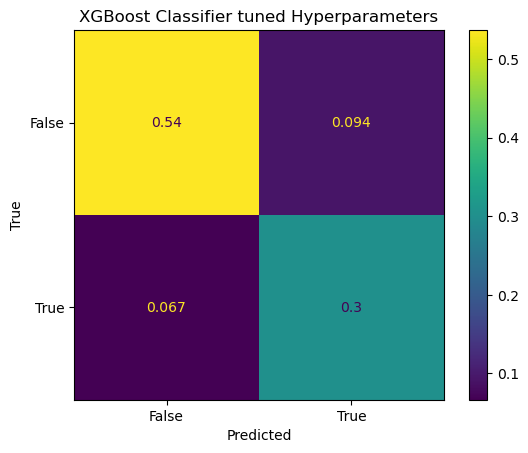

In [26]:
df_tune = dataframe_features('Development', readfile=True)
df_tune.drop(columns=['question1', 'question2'], inplace=True)
df_tune_X = df_tune.loc[:, df_tune.columns!='is_duplicate'].values
df_tune_y = df_tune['is_duplicate'].values
xgb_tuned = XGBClassifier(n_estimators=13499, max_leaves=60, min_child_weight=0.008, learning_rate=0.007, subsample=0.597, colsample_bylevel=0.591, colsample_bytree=1, reg_alpha=0.252, reg_lambda=5.352)
xgb_tuned_true, xgb_tuned_pred = predict_classifier(xgb_tuned, df_tune_X, df_tune_y)
plot_confusionmatrix(xgb_tuned_true, xgb_tuned_pred, 'XGBoost Classifier tuned Hyperparameters', 1, None)

# Final Solution:

In [4]:
def final_predictions(classifier):
    df_train = dataframe_features('Development', readfile=True)
    df_train.drop(columns=['question1', 'question2'], inplace=True)
    df_x_train = df_train.loc[:, df_train.columns!='is_duplicate'].values
    df_y_train = df_train['is_duplicate'].values

    scaler = MinMaxScaler()
    df_x_train = scaler.fit_transform(df_x_train)

    df_test = dataframe_features('Test', readfile=True)
    df_test.drop(columns=['question1', 'question2'], inplace=True)
    df_x_test = scaler.transform(df_test.values)

    classifier.fit(df_x_train, df_y_train)
    df_test['is_duplicate'] = classifier.predict(df_x_test)

    return df_test

# clf = RandomForestClassifier(max_depth=None, min_samples_leaf=4, min_samples_split=7, n_estimators=300)
clf = XGBClassifier(n_estimators=13499, max_leaves=60, min_child_weight=0.008, learning_rate=0.007, subsample=0.597, colsample_bylevel=0.591, colsample_bytree=1, reg_alpha=0.252, reg_lambda=5.352)
df = final_predictions(clf)
df['is_duplicate'].to_csv('results/predictions.csv')